In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from copy import deepcopy
import random
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import json

### Overview

**Baseline config** initial state:  (used in production)   
3 PIDs (engine load, rpm, speed) set to monitoring, with 300 s Min Period (distance, angle, speed delta are not used), min saved records = 1, send period = 120.

**Worst config**  initial state (from my own experience)  
3 PIDs (engine load, rpm, speed) set to on_change, with 300 s Min Period (distance, angle, speed delta are not used), min saved records = 1, send period = 120.

**Test conditions**
1. "Vehicle trip" (test24 since  I am leaning to 12 minutes, or shorter test periods where it's just values increasing monotonically)
2.  Sleep, battery, GPS precision and network mode (home, network, unkown) are assumed optimal. 

**Actions**  
1. $p_{i_0}$----PID (integer identifier for PID, e.g. 12 = RPM)
2. $p_{i_1}$----enable PID $i$   (0 or 1)
3. $p_{i_2}$----change data acquisition strategy for PID $i$  *(monitoring, on_change, hysteresis, delta_change)*  
4. $d_0$------increase/decrease min_time  (time the device lets pass before querying PID values)     *(seconds, 0 disables it)*  
5. $d_1$------increase/decrease min_saved (number of records the device will accumulate before sending) *(int, 0 disables it)*  
6. $d_2$------increase/decrease send_time  (time the device lets pass before attempting to send a new record)  *(seconds, 0 disables it)*  
7. $d_3$------reset baseline  (Device)   *reset to a known stable configuration*  (0,1)
 

For example, considering 3 different PIDs a state $S$ is defined like: 

$S = (p_{00}, p_{01}, p_{02}, p_{10}, p_{11}, p_{12}, p_{20}, p_{21}, p_{22}, d_0, d_1, d_2, d_3)$

So for 3 PIDs, the $S$ vector is of size $13$, and in general:  $3n+ 4$

### PID configuration

In [2]:
STRATEGY_MAP = {
    "monitoring": 0,
    "on_change": 1,
    "hysteresis": 2,
    "on_delta_change": 3 # on_enter, on_exit, on_both are omitted to simplify the model.
}

REVERSE_STRATEGY_MAP = {v: k for k, v in STRATEGY_MAP.items()}
STRATEGY_LIST = list(STRATEGY_MAP.keys())


#####

ACTIVE_PIDS = [12, 13, 39]  # Extend this to more PIDs as needed
n_pids = len(ACTIVE_PIDS)

PID_PRECISION = {
    12: 100,
    13: 5,
    39: 5,
    28: 2,
    38: 3,
    31: 3
}

### State encoder / decoder

In [3]:
def encode_config(config: dict) -> list:
    """
    Converts a human-readable config dict into a state vector.
    """
    vector = []

    # Encode OBD parameters
    for param in config.get("obd_parameters", []):
        pid = param.get("pid", 0)
        enabled = 1 if param.get("enabled", False) else 0
        strategy_idx = STRATEGY_MAP.get(param.get("strategy", "monitoring"), 0)
        vector.extend([pid, enabled, strategy_idx])

    # Global settings
    global_ = config.get("global_settings", {})
    vector.extend([
        global_.get("min_time", 10),
        global_.get("send_period", 10),
        global_.get("min_saved_records", 1)
    ])

    return vector


def decode_config(vector: list) -> dict:
    """
    Converts a state vector into a human-readable config dict.
    """
    config = {"obd_parameters": [], "global_settings": {}}
    n_pids = len(ACTIVE_PIDS)

    # Decode OBD parameter block
    for i in range(n_pids):
        base = i * 3
        pid, enabled, strategy_idx = vector[base:base + 3]
        config["obd_parameters"].append({
            "pid": pid,
            "enabled": bool(enabled),
            "strategy": REVERSE_STRATEGY_MAP.get(strategy_idx, "monitoring")
        })

    # Decode global settings
    g_base = n_pids * 3
    config["global_settings"] = {
        "min_time": vector[g_base],
        "send_period": vector[g_base + 1],
        "min_saved_records": vector[g_base + 2]
    }

    return config

### Actions 

In [4]:
ACTIONS = []

# Toggle PID enable flag
for pid in [12, 13, 39]:
    ACTIONS.append({"type": "toggle", "pid": pid})

# Cycle PID strategy
for pid in [12, 13, 39]:
    ACTIONS.append({"type": "cycle_strategy", "pid": pid})

# Adjust global parameters
ACTIONS.extend([
    {"type": "adjust", "param": "min_time", "delta": -60},
    {"type": "adjust", "param": "min_time", "delta": 60},
    {"type": "adjust", "param": "send_period", "delta": -30},
    {"type": "adjust", "param": "send_period", "delta": 30}
])

In [5]:
n_pids = len(ACTIVE_PIDS)
g_base = n_pids * 3  # index where global settings start

# Per-PID toggle: action_id in 0 to n_pids - 1
# Per-PID strategy: action_id in n_pids to 2 * n_pids - 1
# Global actions: fixed offsets starting from 2 * n_pids

def apply_action(state: list[int], action_id: int, trace: bool = True, baseline: list[int] = None) -> tuple[list[int], dict]:
    """
    Applies a single action to the config vector and returns (new_state, trace_dict).
    The state layout is: [pid, enabled, strategy_idx] * N + [min_time, send_period, min_saved_records]
    """
    new_vector = deepcopy(state)
    trace_info = {}

    n_pids = len(ACTIVE_PIDS)
    g_base = n_pids * 3

    def log(msg):
        if trace:
            print(f"[apply_action] {msg}")
        trace_info["change"] = msg

    # PID toggle: action 0 to N-1
    if action_id < n_pids:
        idx = action_id
        base = idx * 3
        new_vector[base + 1] = 1 - new_vector[base + 1]
        log(f"Toggled PID {new_vector[base]} enable → {new_vector[base + 1]}")
        return new_vector, trace_info

    # PID strategy cycle: action N to 2N-1
    elif action_id < 2 * n_pids:
        idx = action_id - n_pids
        base = idx * 3
        current = new_vector[base + 2]
        new_vector[base + 2] = (current + 1) % len(STRATEGY_LIST)
        log(f"PID {new_vector[base]} strategy: {STRATEGY_LIST[current]} → {STRATEGY_LIST[new_vector[base + 2]]}")
        return new_vector, trace_info

    # Global actions start at 2 * n_pids
    global_actions = {
        0: ("min_time", g_base, 5, 300),
        1: ("min_time", g_base, -5, 1),
        2: ("send_period", g_base + 1, 5, 300),
        3: ("send_period", g_base + 1, -5, 1),
        4: ("min_saved_records", g_base + 2, 1, 10),
        5: ("min_saved_records", g_base + 2, -1, 1),
    }

    global_action_id = action_id - 2 * n_pids

    if global_action_id in global_actions:
        label, index, delta, limit = global_actions[global_action_id]
        old_val = new_vector[index]
        new_val = old_val + delta
        new_val = max(min(new_val, max(limit, old_val)), min(limit, old_val))
        new_vector[index] = new_val
        log(f"{label} changed from {old_val} → {new_val}")
        return new_vector, trace_info

    # Reset to baseline
    if global_action_id == 6 and baseline is not None:
        new_vector = deepcopy(baseline)
        log("Reset to baseline configuration")
        return new_vector, trace_info

    log(f"No change for action_id={action_id}")
    return new_vector, trace_info


### Reward function

reward = latency_score + sum(pid_scores)


compute_reward() inputs: 
    latency_ms: int
    pid_data_list: list of dictionaries

For example:    
    latency_ms = 1850
```json
    pid_data_list = [
        {
            "pid": 12,
            "values": [1500, 1500, 1500],
            "strategy": "on_change",
            "precision": 100,
            "valid_range": (800, 6000)
        },
        // rest of the PIDs
]```

**Precision**
    This defines how much a value must change to be considered “meaningful.”
    Even if all values are valid, we may want to ignore tiny fluctuations (e.g., RPM changes by 1 unit) and log only useful variation (e.g., ±100 RPM).

In [6]:
def latency_score(latency_ms: int) -> float:
    """Scores latency from 1.0 (fast) to -0.5 (excessive delay)."""
    if latency_ms <= 2000:
        return 1.0
    elif latency_ms <= 10000:
        return 1 - (latency_ms - 2000) / 8000
    elif latency_ms <= 30000:
        return 0 - (latency_ms - 10000) / 20000 * 0.5
    else:
        return -0.5
    

def compute_pid_scores(pid_data_list: list[dict]) -> list[dict]:
    """Computes per-PID scores based on precision, strategy, and value variation."""
    scores = []
    for entry in pid_data_list:
        score = data_quality_score(
            values=entry["values"],
            strategy=entry["strategy"],
            precision=entry["precision"],
            valid_range=entry["valid_range"]
        )
        scores.append({
            "pid": entry["pid"],
            "score": round(score, 3)
        })
    return scores


def data_quality_score(
    values: list[float],
    strategy: str,
    precision: float,
    valid_range: tuple[float, float],
) -> float:
    """Scores a PID’s quality based on value range, variation, and strategy."""
    if not values:
        return -1.0

    # 1. Range check
    if not all(valid_range[0] <= v <= valid_range[1] for v in values):
        return -1.0

    # 2. Variation check
    variation = max(values) - min(values)
    significant = variation >= precision

    # 3. Strategy match
    if strategy == "on_change":
        return 1.0 if not significant else 0.5
    elif strategy == "on_delta_change":
        return 1.0 if significant else -0.5
    elif strategy == "hysteresis":
        return 0.8 if significant else 0.2
    elif strategy == "monitoring":
        return 0.6 if significant else -0.2

    return 0.0  # fallback



def compute_average_quality(pid_data_list: list[dict]) -> float:
    """Returns sum of quality scores for all PIDs (no weighting)."""
    scores = [data_quality_score(**entry) for entry in pid_data_list]
    return round(sum(scores), 3) if scores else 0.0


def clip_reward(score, min_val=-1.0, max_val=3.0):
    """Optional clipping to stabilize training and limit outliers."""
    return max(min(score, max_val), min_val)


def compute_reward(latency_ms: int, pid_data_list: list[dict]) -> float:
    """Simple reward = latency score + sum of PID quality scores."""
    latency = latency_score(latency_ms)
    quality_sum = compute_average_quality(pid_data_list)
    return round(latency + quality_sum, 3)


def compute_reward_with_details(latency_ms: int, pid_data_list: list[dict]) -> tuple[float, dict]:
    """
    Returns:
    - Total reward score
    - Breakdown with latency and individual PID scores
    """
    for entry in pid_data_list:
        entry["precision"] = PID_PRECISION.get(entry["pid"], 1)

    latency = latency_score(latency_ms)
    pid_scores = compute_pid_scores(pid_data_list)
    total_pid_score = sum(entry["score"] for entry in pid_scores)
    total_reward = round(latency + total_pid_score, 3)

    breakdown = {
        "latency_ms": latency_ms,
        "latency_score": round(latency, 3),
        "pid_scores": pid_scores,
        "total_pid_score": round(total_pid_score, 3),
    }

    return total_reward, breakdown

In [7]:
def flag_latency_outliers(freq_df: pd.DataFrame, threshold_ms: int = 7_200_000) -> pd.DataFrame:
    """
    Adds a boolean column 'is_latency_outlier' to the input DataFrame,
    where True indicates latency greater than the given threshold (default: 2 hours).
    """

    # Convert timestamps
    freq_df["ts_recorded"] = pd.to_datetime(freq_df["ts_recorded"])
    freq_df["ts_uploaded"] = pd.to_datetime(freq_df["ts_uploaded"])

    # Compute latency in milliseconds
    freq_df["latency_ms"] = (freq_df["ts_uploaded"] - freq_df["ts_recorded"]).dt.total_seconds() * 1000

    # Flag all rows with latency above the threshold
    freq_df["is_latency_outlier"] = freq_df["latency_ms"] > threshold_ms

    return freq_df


def get_latency(start_ts, end_ts, method='median'):
    freq_df = pd.read_csv('../../data_proc/csv_data/qa_device/frequencies.csv', low_memory=False)
    freq_df.drop('Unnamed: 0', inplace=True, axis=1)

    # Parse timestamps
    freq_df["ts_recorded"] = pd.to_datetime(freq_df["ts_recorded"])
    freq_df["ts_uploaded"] = pd.to_datetime(freq_df["ts_uploaded"])

    # Filter within time range
    mask = (freq_df["ts_recorded"] >= pd.to_datetime(start_ts)) & (freq_df["ts_recorded"] <= pd.to_datetime(end_ts))
    filtered_df = freq_df[mask].copy()

    if filtered_df.empty:
        return None  # or raise an exception if preferred

    # Compute latency in ms
    filtered_df["latency_ms"] = (filtered_df["ts_uploaded"] - filtered_df["ts_recorded"]).dt.total_seconds() * 1000

    if method == 'median':
        return filtered_df["latency_ms"].median()
    elif method == 'mean':
        return filtered_df["latency_ms"].mean()
    else:
        raise ValueError("method must be 'median' or 'mean'")


# Define a field-to-PID mapping
FIELD_TO_PID = {
    "obd.rpm.value": 12,
    "obd.speed.value": 13,
    "obd.fuel_level.value": 28,
    "obd.coolant_temp.value": 38,
    "obd.engine_load.value": 39,
    "obd.intake_temp.value": 20,
    "obd.maf.value": 21,
    "obd.throttle_pos.value": 41,
    "obd.ambient_air_temp.value": 131,
    "obd.distance_since_codes_clear.value": 31,
    "obd.time_since_codes_cleared.value": 47,
    # Add more as needed...
}


def extract_pid_statistics(obd_df: pd.DataFrame, start_ts: str, end_ts: str) -> list[dict]:
    """
    Extracts per-PID reward inputs (PID ID, values, precision, valid range)
    from an obd_export dataframe filtered by timestamp range.
    Returns a list of dictionaries ready for reward scoring.
    """
    # Filter by time window
    obd_df["@ts"] = pd.to_datetime(obd_df["@ts"])
    mask = (obd_df["@ts"] >= pd.to_datetime(start_ts)) & (obd_df["@ts"] <= pd.to_datetime(end_ts))
    obd_df = obd_df[mask].copy()

    results = []

    for field, pid in FIELD_TO_PID.items():
        if field not in obd_df.columns:
            continue

        values = obd_df[field].dropna().astype(float).tolist()
        if not values:
            continue

        vmin, vmax = min(values), max(values)
        vrange = vmax - vmin

        precision = round(vrange * 0.1, 3) if vrange > 0 else 1.0
        valid_range = (vmin - vrange * 0.1, vmax + vrange * 0.1)

        results.append({
            "pid": pid,
            "values": values,
            "precision": precision,
            "valid_range": valid_range
        })

    return results

In [8]:
def summarize_pid_statistics(pid_data_list: list[dict]) -> pd.DataFrame:
    """
    Returns a DataFrame summarizing each PID's stats (excluding raw values).
    """
    summary = []

    for entry in pid_data_list:
        values = entry["values"]
        pid_summary = {
            "PID": entry["pid"],
            "Count": len(values),
            "Min": min(values) if values else None,
            "Max": max(values) if values else None,
            "Precision": PID_PRECISION.get(entry["pid"], 1),
            "Valid Range": entry["valid_range"],
        }
        summary.append(pid_summary)

    return pd.DataFrame(summary).sort_values(by="PID")


### Q-Agent

In [9]:
class QAgent:
    def __init__(self, action_space_size, epsilon=0.2, alpha=0.5, gamma=0.9):
        self.q_table = defaultdict(lambda: [0.0] * action_space_size)
        self.epsilon = epsilon  # exploration rate
        self.alpha = alpha      # learning rate
        self.gamma = gamma      # discount factor
        self.action_space_size = action_space_size

    def select_action(self, state_vector: list[int]) -> int:
        state_key = tuple(state_vector)

        if random.random() < self.epsilon:
            return random.randint(0, self.action_space_size - 1)  # explore
        else:
            q_values = self.q_table[state_key]
            return int(q_values.index(max(q_values)))  # exploit

    def update(self, state: list[int], action: int, reward: float, next_state: list[int]):
        state_key = tuple(state)
        next_state_key = tuple(next_state)

        old_value = self.q_table[state_key][action]
        next_max = max(self.q_table[next_state_key])

        # Q-learning update rule
        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
        self.q_table[state_key][action] = new_value

    def decay_epsilon(self, decay_rate=0.99):
        self.epsilon *= decay_rate

    def save_q_table(self, path='q_table.json'):
        # Convert keys to strings for JSON serialization
        json_q = {str(k): v for k, v in self.q_table.items()}
        with open(path, 'w') as f:
            json.dump(json_q, f, indent=2)

    def load_q_table(self, path='q_table.json'):
        with open(path, 'r') as f:
            json_q = json.load(f)
        self.q_table = defaultdict(lambda: [0.0] * self.action_space_size)
        for k, v in json_q.items():
            self.q_table[tuple(eval(k))] = v


### Vehicle trip simulation / Q-Agent training

1. Start from a known config (state)
2. Select an action with ε-greedy
3. Applies it to get next_state
4. Run run_vehicle_sim() to compute reward
5. Update Q-table
6. Repeat for N episodes

In [24]:
def run_vehicle_sim(config_vector, trip_df, trace=False):
    from copy import deepcopy

    config = decode_config(config_vector)
    pid_data_list = []

    # Parse timestamps
    trip_df["ts_recorded"] = pd.to_datetime(trip_df["ts_recorded"], utc=True, errors="coerce")
    trip_df["ts_uploaded"] = pd.to_datetime(trip_df["ts_uploaded"], utc=True, errors="coerce")
    trip_df = trip_df.dropna(subset=["ts_recorded", "ts_uploaded"])

    if trip_df.empty:
        if trace:
            print("[run_vehicle_sim] trip_df is EMPTY after filtering.")
        return -0.5, {"latency_ms": float("nan"), "latency_score": -0.5, "pid_scores": [], "total_pid_score": 0.0}

    for param in config["obd_parameters"]:
        if not param["enabled"]:
            continue

        pid = param["pid"]
        strategy = param["strategy"]

        if pid == 12:
            values = trip_df["obd_rpm"].tolist()
            valid_range = (0, 8000)
        elif pid == 13:
            values = trip_df["obd_speed"].tolist()
            valid_range = (0, 250)
        elif pid == 39:
            values = trip_df["obd_engine_load"].tolist()
            valid_range = (0, 100)
        else:
            continue

        pid_data_list.append({
            "pid": pid,
            "values": values,
            "strategy": strategy,
            "valid_range": valid_range
        })

    latency_ms = (trip_df["ts_uploaded"] - trip_df["ts_recorded"]).dt.total_seconds().mean() * 1000

    reward, breakdown = compute_reward_with_details(latency_ms, pid_data_list)

    if trace:
        print(f"Reward: {reward:.2f}, Latency: {latency_ms:.1f} ms, Breakdown: {breakdown}")

    return reward, breakdown


In [22]:
def train_q_agent(
    agent,
    baseline_config_vector,
    start_ts,
    end_ts,
    obd_csv_path,
    episodes=30,
    trace=True
):
    import pandas as pd
    from dateutil.parser import isoparse

    # Load and filter OBD data
    df = pd.read_csv(obd_csv_path)
    df["ts_recorded"] = pd.to_datetime(df["ts_recorded"])
    start_dt, end_dt = pd.to_datetime(start_ts), pd.to_datetime(end_ts)
    df_trip = df[(df["ts_recorded"] >= start_dt) & (df["ts_recorded"] <= end_dt)].copy()

    state = baseline_config_vector.copy()
    rewards_per_episode = []

    for ep in range(episodes):
        action = agent.select_action(state)
        next_state, trace_info = apply_action(state, action, trace=False, baseline=baseline_config_vector)

        try:
            reward, breakdown = run_vehicle_sim(
                config_vector=next_state,
                trip_df=df_trip,
                trace=False
            )
        except Exception as e:
            print(f"[Episode {ep}] Simulation failed: {e}")
            reward = -1.0
            breakdown = {
                "latency_ms": float("nan"),
                "latency_score": -0.5,
                "pid_scores": [],
                "total_pid_score": 0.0
            }

        agent.update(state, action, reward, next_state)
        rewards_per_episode.append(reward)
        state = next_state

        if trace:
            print(f"[Episode {ep}] Latency: {breakdown['latency_ms']:.0f} ms")
            print(f"[Episode {ep}] Action: {action}, Reward: {reward:.3f}")

        agent.decay_epsilon()

    return rewards_per_episode

In [20]:
with open('./device_config/config_0.json', "r") as json_file:
    config_0 = json.load(json_file)
    c_vector = encode_config(config_0)
    print("Config vector:", c_vector)

start_time = "2025-05-27T20:01:26Z"
end_time = "2025-05-27T20:13:26Z"
obd_csv_path = './es_events/obd_data_1.csv'

agent = QAgent(
    action_space_size=len(ACTIONS),
    epsilon=0.2,
    alpha=0.5,
    gamma=0.9
)

Config vector: [12, 1, 0, 13, 1, 0, 39, 1, 0, 300, 120, 1]


In [25]:
rewards = train_q_agent(
    agent=agent,
    baseline_config_vector=c_vector,
    start_ts=start_time,
    end_ts=end_time,
    obd_csv_path=obd_csv_path,
    episodes=30,  # or start with fewer like 10
    trace=True
)

[Episode 0] Latency: 3510 ms
[Episode 0] Action: 3, Reward: 1.711
[Episode 1] Latency: 3510 ms
[Episode 1] Action: 0, Reward: 1.211
[Episode 2] Latency: 3510 ms
[Episode 2] Action: 5, Reward: 2.411
[Episode 3] Latency: 3510 ms
[Episode 3] Action: 0, Reward: 2.911
[Episode 4] Latency: 3510 ms
[Episode 4] Action: 0, Reward: 2.411
[Episode 5] Latency: 3510 ms
[Episode 5] Action: 0, Reward: 2.911
[Episode 6] Latency: 3510 ms
[Episode 6] Action: 0, Reward: 2.411
[Episode 7] Latency: 3510 ms
[Episode 7] Action: 0, Reward: 2.911
[Episode 8] Latency: 3510 ms
[Episode 8] Action: 0, Reward: 2.411
[Episode 9] Latency: 3510 ms
[Episode 9] Action: 8, Reward: 2.411
[Episode 10] Latency: 3510 ms
[Episode 10] Action: 0, Reward: 2.911
[Episode 11] Latency: 3510 ms
[Episode 11] Action: 0, Reward: 2.411
[Episode 12] Latency: 3510 ms
[Episode 12] Action: 0, Reward: 2.911
[Episode 13] Latency: 3510 ms
[Episode 13] Action: 7, Reward: 2.911
[Episode 14] Latency: 3510 ms
[Episode 14] Action: 0, Reward: 2.411


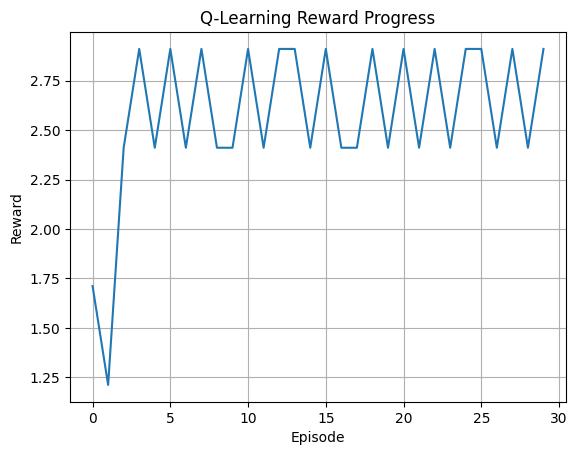

In [26]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Q-Learning Reward Progress")
plt.grid(True)
plt.show()

In [27]:
agent.save_q_table("q_table_config0.json")

In [28]:
for state, q_values in agent.q_table.items():
    best_action = q_values.index(max(q_values))
    print(f"State: {state} → Best action: {best_action}")

State: (12, 1, 0, 13, 1, 0, 39, 1, 0, 300, 120, 1) → Best action: 3
State: (12, 0, 0, 13, 1, 0, 39, 1, 0, 300, 120, 1) → Best action: 0
State: (12, 1, 0, 13, 0, 0, 39, 1, 0, 300, 120, 1) → Best action: 2
State: (12, 0, 0, 13, 0, 0, 39, 1, 0, 300, 120, 1) → Best action: 1
State: (12, 1, 0, 13, 1, 0, 39, 0, 0, 300, 120, 1) → Best action: 1
State: (12, 0, 0, 13, 1, 0, 39, 0, 0, 300, 120, 1) → Best action: 1
State: (12, 1, 0, 13, 1, 0, 39, 0, 0, 300, 115, 1) → Best action: 1
State: (12, 0, 0, 13, 1, 0, 39, 0, 0, 300, 115, 1) → Best action: 0
State: (12, 0, 0, 13, 1, 0, 39, 0, 0, 295, 115, 1) → Best action: 1
State: (12, 1, 0, 13, 1, 0, 39, 0, 0, 295, 115, 1) → Best action: 2
State: (12, 1, 0, 13, 0, 0, 39, 0, 0, 295, 115, 1) → Best action: 0
State: (12, 0, 0, 13, 0, 0, 39, 0, 0, 295, 115, 1) → Best action: 3
State: (12, 0, 0, 13, 0, 0, 39, 1, 0, 295, 115, 1) → Best action: 2
State: (12, 1, 0, 13, 0, 0, 39, 1, 0, 295, 115, 1) → Best action: 1
State: (12, 0, 0, 13, 1, 0, 39, 1, 0, 295, 115, 

### Unit tests


In [14]:
### Helper functions

def generate_random_config() -> dict:
    config = {
        "obd_parameters": [],
        "global_settings": {}
    }

    for pid in ACTIVE_PIDS:
        enabled = random.choice([True, False])
        strategy = random.choice(STRATEGY_LIST)
        config["obd_parameters"].append({
            "pid": pid,
            "enabled": enabled,
            "strategy": strategy
        })

    config["global_settings"] = {
        "min_time": random.choice([5, 10, 30, 60, 120, 300]),
        "send_period": random.choice([10, 30, 60, 120, 300]),
        "min_saved_records": random.randint(1, 10)
    }

    return config

In [15]:
raise StopIteration("Manual testing block below. Execution stopped.")

StopIteration: Manual testing block below. Execution stopped.

#### Encode / decode

In [ ]:
config = {
    "obd_parameters": [
        {"pid": 12, "enabled": True, "strategy": "on_change"},
        {"pid": 13, "enabled": True, "strategy": "monitoring"},
        {"pid": 39, "enabled": False, "strategy": "hysteresis"},
    ],
    "global_settings": {
        "min_time": 10,
        "send_period": 60,
        "min_saved_records": 1
    }
}

vec = encode_config(config)
decoded = decode_config(vec)
assert config == decoded  # Should pass


#### Apply action

In [ ]:
def test_apply_action_on_all_ids():
    base_config = generate_random_config()
    baseline_vector = encode_config(base_config)
    print("Base Config:", decode_config(baseline_vector))

    n_pids = len(ACTIVE_PIDS)
    total_actions = len(ACTIONS)

    for action_id in range(total_actions):
        print(f"\n--- Testing action {action_id} ---")
        new_vector, trace = apply_action(baseline_vector, action_id, trace=True, baseline=baseline_vector)

        # Assert same length
        assert len(new_vector) == len(baseline_vector), f"Vector length changed for action {action_id}"

        # Assert valid strategy index
        for i in range(n_pids):
            strategy_idx = new_vector[i * 3 + 2]
            assert 0 <= strategy_idx < len(STRATEGY_LIST), f"Invalid strategy index {strategy_idx} after action {action_id}"

        # Global settings sanity check
        g_base = n_pids * 3
        assert new_vector[g_base] >= 1, "min_time below 1"
        assert new_vector[g_base + 1] >= 1, "send_period below 1"
        assert 1 <= new_vector[g_base + 2] <= 10, "min_saved_records out of bounds"

        print("Trace:", trace)
        print("✅ Passed all assertions for action", action_id)

In [ ]:
test_apply_action_on_all_ids()

Base Config: {'obd_parameters': [{'pid': 12, 'enabled': True, 'strategy': 'monitoring'}, {'pid': 13, 'enabled': False, 'strategy': 'on_delta_change'}, {'pid': 39, 'enabled': True, 'strategy': 'on_delta_change'}], 'global_settings': {'min_time': 300, 'send_period': 60, 'min_saved_records': 9}}

--- Testing action 0 ---
[apply_action] Toggled PID 12 enable → 0
Trace: {'change': 'Toggled PID 12 enable → 0'}
✅ Passed all assertions for action 0

--- Testing action 1 ---
[apply_action] Toggled PID 13 enable → 1
Trace: {'change': 'Toggled PID 13 enable → 1'}
✅ Passed all assertions for action 1

--- Testing action 2 ---
[apply_action] Toggled PID 39 enable → 0
Trace: {'change': 'Toggled PID 39 enable → 0'}
✅ Passed all assertions for action 2

--- Testing action 3 ---
[apply_action] PID 12 strategy: monitoring → on_change
Trace: {'change': 'PID 12 strategy: monitoring → on_change'}
✅ Passed all assertions for action 3

--- Testing action 4 ---
[apply_action] PID 13 strategy: on_delta_change 

#### Q-Agent

In [ ]:
def test_qagent_basic():
    agent = QAgent(action_space_size=13, epsilon=0.0)  # deterministic
    state = encode_config({
        "obd_parameters": [
            {"pid": 12, "enabled": True, "strategy": "on_change"},
            {"pid": 13, "enabled": True, "strategy": "on_change"},
            {"pid": 39, "enabled": True, "strategy": "on_change"}
        ],
        "global_settings": {"min_time": 10, "send_period": 60, "min_saved_records": 1}
    })

    action = agent.select_action(state)
    next_state, _ = apply_action(state, action, baseline=state)
    reward = 2.5
    agent.update(state, action, reward, next_state)

    # Assert Q-value updated
    state_key = tuple(state)
    assert action < len(agent.q_table[state_key]), "Q-table entry missing"
    q_value = agent.q_table[state_key][action]
    assert q_value != 0.0, "Q-value not updated"
    print(f"✅ Q-table updated: Q[state][{action}] = {q_value:.3f}")

In [ ]:
test_qagent_basic()

[apply_action] Toggled PID 12 enable → 0
✅ Q-table updated: Q[state][0] = 1.250


In [ ]:
def test_qagent_training():
    baseline_config = {
        "obd_parameters": [
            {"pid": 12, "enabled": True, "strategy": "monitoring"},
            {"pid": 13, "enabled": True, "strategy": "monitoring"},
            {"pid": 39, "enabled": True, "strategy": "monitoring"}
        ],
        "global_settings": {"min_time": 300, "send_period": 120, "min_saved_records": 1}
    }

    baseline_vector = encode_config(baseline_config)
    agent = QAgent(action_space_size=13, epsilon=0.3)

    rewards = train_q_agent(
        agent,
        baseline_vector,
        start_ts="2025-05-16T06:40:38Z",
        end_ts="2025-05-17T23:59:00Z"  ,
        freq_csv_path="../../data_proc/csv_data/qa_device/frequencies.csv",
        obd_csv_path="../../data_proc/csv_data/qa_device/obd_export.csv",
        episodes=5,
        trace=True
    )

    assert len(rewards) == 5, "Incorrect number of training episodes"
    assert all(isinstance(r, (float, int)) for r in rewards), "Non-numeric reward detected"
    print("✅ Training rewards:", rewards)

In [ ]:
test_qagent_training()

[Episode 0] Action: 0, Reward: 1.700
[Episode 1] Action: 0, Reward: 1.700
[Episode 2] Action: 0, Reward: 1.700
[Episode 3] Action: 0, Reward: 1.700
[Episode 4] Action: 0, Reward: 1.700
✅ Training rewards: [1.7, 1.7, 1.7, 1.7, 1.7]


In [ ]:
### Training

baseline_config = {
    "obd_parameters": [
        {"pid": 12, "enabled": True, "strategy": "monitoring"},
        {"pid": 13, "enabled": True, "strategy": "monitoring"},
        {"pid": 39, "enabled": True, "strategy": "monitoring"}
    ],
    "global_settings": {"min_time": 300, "send_period": 120, "min_saved_records": 1}
}

baseline_vector = encode_config(baseline_config)

agent = QAgent(action_space_size=13, epsilon=0.3)
rewards = train_q_agent(
    agent,
    baseline_vector,
    start_ts="2025-05-23T13:55:00Z",
    end_ts="2025-05-23T14:07:00Z",
    freq_csv_path="frequencies.csv",
    obd_csv_path="obd_export.csv"
)

plot_rewards(rewards)

### References



**Implementation references**

- OpenAI Spinning Up: https://spinningup.openai.com
Although it focuses more on policy-gradient methods, it gives good context on where Q-learning fits in the broader RL ecosystem.

- RL Course by David Silver (DeepMind)
Lectures 4–6 cover model-free methods, including Q-Learning.

- Towards Data Science
https://towardsdatascience.com/reinforcement-learning-explained-visually-part-4-q-learning-step-by-step-b65efb731d3e/



**Academic references**

1. Watkins, C.J.C.H., & Dayan, P. (1992)
   Q-learning: https://link.springer.com/article/10.1007/BF00992698

   
2. Sutton, R. S., & Barto, A. G. (2018)
    Reinforcement Learning: An Introduction (2nd Edition)
    Chapter 6 covers Q-Learning in depth.
    http://incompleteideas.net/book/the-book-2nd.html 